# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ __(5 pts)__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ __(bonus: 5 pts each)__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params), show graphs for different params
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. 
* 20-neuron network is probably not enough, feel free to experiment.

In [1]:
%pip install gym==0.14
%pip install swig
%pip install ufal.pybox2d
%pip install pyglet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import gym
import time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

time.clock = time.time
# env = #choose 1 env - for example: gym.make("MountainCar-v0").env
env = gym.make("LunarLander-v2").env

env.reset()
n_actions = env.action_space.n

In [3]:
def generate_session(t_max=2000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])
        probs = np.reshape(probs, (-1))

        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)

        total_reward += r
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [4]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()]*n_actions,range(n_actions));

c:\Users\ohmei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
from IPython.display import clear_output

def show_progress(rewards_batch,log, reward_range=[-5000,+5000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    #print(rewards_batch)
    reward_range=[-1010,+10]
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [6]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=70):
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    n = len(states_batch)
    elite_states = [states_batch[i] for i in range(n) if rewards_batch[i] > reward_threshold]
    elite_actions = [actions_batch[i] for i in range(n) if rewards_batch[i] > reward_threshold]

    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)

    elite_actions = np.hstack(elite_actions)
    return elite_states,elite_actions, reward_threshold

In [7]:
def visualize(t_max=5000):
    
    env_for_fun = gym.make("LunarLander-v2")
    s = env_for_fun.reset()
    
    for t in range(t_max):
        env_for_fun.render()

        try:
            probs = agent.predict_proba([s])[0]
        except Exception:
            probs = np.ones([n_actions]) / n_actions

        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env_for_fun.step(a)
    
        s = new_s
        if done: break
    
    env_for_fun.close()

In [8]:
visualize()

mean reward = 57.071, threshold=43.441


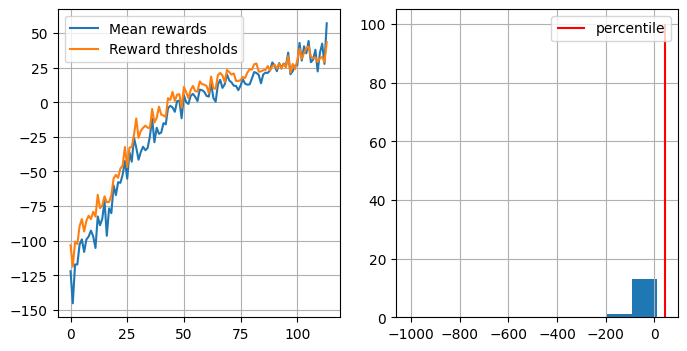

Time: 2456.548216342926
You Win!
Time: 2456.548216342926


In [19]:
import time
n_sessions = 100
percentile = 50
log = []
startTime = time.time()

for i in range(10000):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions, threshold = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)
    
    #fit agent
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if np.mean(rewards_batch) >= 50:
       print("You Win!")
       break;

print("Time:", time.time() - startTime)
for i in range(3):
    visualize()


SPEEED

mean reward = 77.176, threshold=52.413


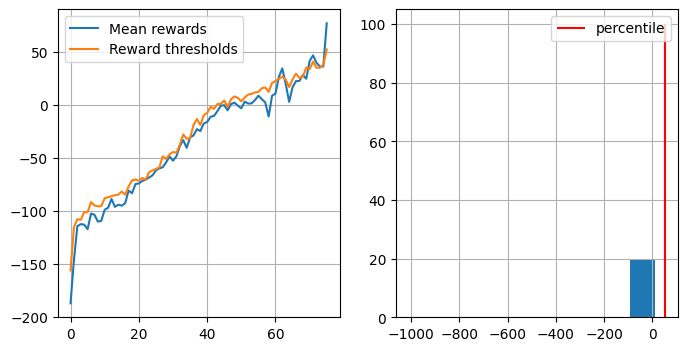

Time: 422.94564986228943
You Win!
Time: 422.94663977622986


In [22]:
from joblib import Parallel, delayed
import time
n_sessions = 100
percentile = 50
log = []
startTime = time.time()

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()]*n_actions,range(n_actions));

for i in range(10000):
    #generate new sessions
    sessions = Parallel(n_jobs=-2)(delayed(generate_session)() for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions, threshold = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)
    
    #fit agent
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if np.mean(rewards_batch) >= 50:
       print("You Win!")
       break;

print("Time:", time.time() - startTime)
for i in range(3):
    visualize()

3-5 last iterations

In [6]:
def select_elites(states_batch,actions_batch,rewards_batch,n_sessions,percentile=70):
    reward_threshold = np.percentile(rewards_batch, percentile)

    states_batch = states_batch[len(states_batch) - n_sessions:]
    actions_batch = actions_batch[len(actions_batch) - n_sessions:]
    rewards_batch = rewards_batch[len(rewards_batch) - n_sessions:]
    
    n = len(states_batch)
    elite_states = [states_batch[i] for i in range(n) if rewards_batch[i] > reward_threshold]
    elite_actions = [actions_batch[i] for i in range(n) if rewards_batch[i] > reward_threshold]

    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)

    elite_actions = np.hstack(elite_actions)
    return elite_states,elite_actions, reward_threshold

mean reward = 55.465, threshold=30.602


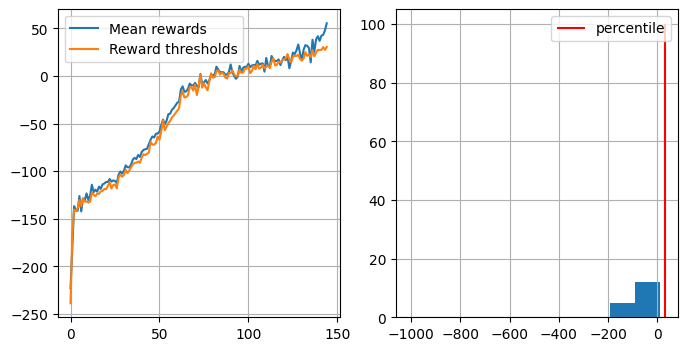

Time: 694.8503053188324
You Win!
Time: 694.8503053188324


In [27]:
from joblib import Parallel, delayed
import time
n_sessions = 100
percentile = 40
log = []
startTime = time.time()

lastIters = 3

allStates = []
allActions = []
allRewards = []

agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()]*n_actions,range(n_actions));

for i in range(10000):
    if (i % 10 == 0):
        for j in range(3):
            visualize();
    
    #generate new sessions
    sessions = Parallel(n_jobs=-2)(delayed(generate_session)() for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = zip(*sessions)
    for state in states_batch:
        allStates.append(state)
    for action in actions_batch:
        allActions.append(action)
    for reward in rewards_batch:
        allRewards.append(reward)

    if (i >= lastIters):
        allStates = allStates[n_sessions:]
        allActions = allActions[n_sessions:]
        allRewards = allRewards[n_sessions:]

    elite_states, elite_actions, threshold = select_elites(allStates,allActions,np.array(allRewards),n_sessions,percentile)
    
    #fit agent
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if np.mean(rewards_batch) >= 50:
       print("You Win!")
       break;

print("Time:", time.time() - startTime)
for i in range(3):
    visualize()

На самом деле моделька обучается быстрее, но почему-то не регистрирует посадку, пока зонд не коснется телом поверхности (есть много итераций, где садится на ножки, а за посадку это не считается)

In [28]:
for i in range(10):
    visualize()

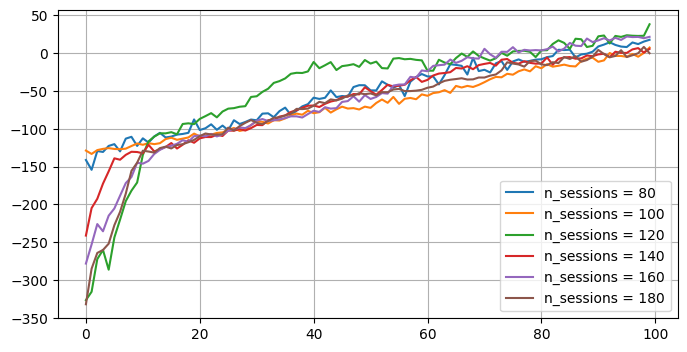

Time: 2406.5747208595276


In [27]:
from joblib import Parallel, delayed
import time
ns_sessions = [i for i in range(80, 200, 20)]
percentile = 40
log = []
startTime = time.time()

lastIters = 3

allStates = []
allActions = []
allRewards = []



allMeans = []

def show(mean, itr):
    # print(mean, itr)
    clear_output(True)
    plt.figure(figsize=[8,4])
    for i in range(len(mean)):
        plt.plot(mean[i], label="n_sessions = " + str(itr[i]))
    plt.legend()
    plt.grid()
    
    plt.show()

cnt_sessions = []

for n_sessions in ns_sessions:
    agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                        activation='tanh',
                        warm_start=True, #keep progress between .fit(...) calls
                        max_iter=1 #make only 1 iteration on each .fit(...)
                        )
    agent.fit([env.reset()]*n_actions,range(n_actions));
    allStates = []
    allActions = []
    allRewards = []
    means = []
    cnt_sessions.append(n_sessions)
    for i in range(100):
        
        #generate new sessions
        sessions = Parallel(n_jobs=-2)(delayed(generate_session)() for _ in range(n_sessions))

        states_batch,actions_batch,rewards_batch = zip(*sessions)
        for state in states_batch:
            allStates.append(state)
        for action in actions_batch:
            allActions.append(action)
        for reward in rewards_batch:
            allRewards.append(reward)

        if (i >= lastIters):
            allStates = allStates[n_sessions:]
            allActions = allActions[n_sessions:]
            allRewards = allRewards[n_sessions:]

        elite_states, elite_actions, threshold = select_elites(allStates,allActions,np.array(allRewards),n_sessions,percentile)
        
        #fit agent
        agent.fit(elite_states, elite_actions)

        means.append(np.array(rewards_batch).mean())
        allMeans.append(means);
        show(allMeans, cnt_sessions)
        allMeans.pop()
    allMeans.append(means)


print("Time:", time.time() - startTime)

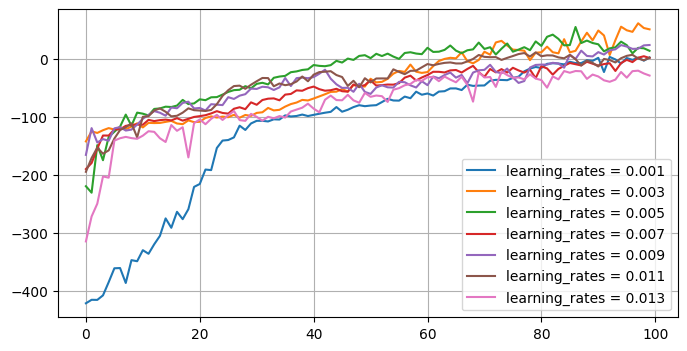

Time: 2147.869925737381


In [7]:
from joblib import Parallel, delayed
import time
n_sessions = 100
lrs = [i / 1000 for i in range(1, 14, 2)]

percentile = 40
log = []
startTime = time.time()

lastIters = 3

allStates = []
allActions = []
allRewards = []

allMeans = []

def show(mean, curRates):
    # print(mean, itr)
    clear_output(True)
    plt.figure(figsize=[8,4])
    for i in range(len(mean)):
        plt.plot(mean[i], label="learning_rates = " + str(curRates[i]))
    plt.legend()
    plt.grid()
    
    plt.show()

cnt_sessions = []
curRates = []

for learning_rate in lrs:
    agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                        activation='tanh',
                        warm_start=True, #keep progress between .fit(...) calls
                        max_iter=1, #make only 1 iteration on each .fit(...)
                        learning_rate_init=learning_rate
                        )
    agent.fit([env.reset()]*n_actions,range(n_actions));

    means = []
    allStates = []
    allActions = []
    allRewards = []
    curRates.append(learning_rate)
    for i in range(100):
        
        #generate new sessions
        sessions = Parallel(n_jobs=-2)(delayed(generate_session)() for _ in range(n_sessions))

        states_batch,actions_batch,rewards_batch = zip(*sessions)
        for state in states_batch:
            allStates.append(state)
        for action in actions_batch:
            allActions.append(action)
        for reward in rewards_batch:
            allRewards.append(reward)

        if (i >= lastIters):
            allStates = allStates[n_sessions:]
            allActions = allActions[n_sessions:]
            allRewards = allRewards[n_sessions:]

        elite_states, elite_actions, threshold = select_elites(allStates,allActions,np.array(allRewards),n_sessions,percentile)
        
        #fit agent
        agent.fit(elite_states, elite_actions)

        means.append(np.array(rewards_batch).mean())
        allMeans.append(means);
        show(allMeans, curRates)
        allMeans.pop()
    allMeans.append(means)


print("Time:", time.time() - startTime)

Было очень весело сажать луноход и очень сильно горело, когда вроде посадил, а попытку не регистрировало (очень сильно (прямо очень (нет правда))).

Но таска оч веселая, но горело сильно.

Было интересно разобраться в распараллеливании процессов и непонятно, почему я так страдал раньше, обучая модельки немалое количество времени. 

Штука с обучение на 3 последних итерациях тоже очень интересная и страхует от сильных ошибок (конкретно на этой задаче просто график меньше колбасит, а работает даже дольше))

Кажется, что качество от количества сессий и lr зависит в целом параболлически (хз как это назвать, квадратично мб (Антон Ны под руку чето там говорит)). Ну короче сначала лучше становится, потом хуже. В целом вроде даже могу это объяснить, но здесь не буду.

Всем спасибо за просмотр, дорогие подписчики, ставьте лайки, подписывайтесь на репозиторий, всем пока!!